# Deep Learning: Assignment #4
## Submission date: 28/01/2026, 23:59.
### Topics:
- Word Embeddings
- Transformers
- Vision Transformers
- Few-Shot Learning
- Self-Supervised Learning


**Submitted by:**

- **Student 1 — Mahmoud Abade, 206773756**
- **Student 2 — Firas Dwere, 214225021**


**Assignment Instructions:**

· Submissions are in **pairs only**. Write both names + IDs at the top of the notebook.

· Keep your code **clean, concise, and readable**.

· You may work in your IDE, but you **must** paste the final code back into the **matching notebook cells** and run it there.  


· <font color='red'>Write your textual answers in red.</font>  
(e.g., `<span style="color:red">your answer here</span>`)

· All figures, printed results, and outputs should remain visible in the notebook.  
Run **all cells** before submitting and **do not clear outputs**.

· Use relative paths — **no absolute file paths** pointing to local machines.

· **Important:** Your submission must be entirely your own.  
Any form of plagiarism (including uncredited use of ChatGPT or AI tools) will result in **grade 0** and disciplinary action.


In [1]:
# Global Setup

import os
import re
import math
import random
from collections import defaultdict, Counter
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## Question 1: Learning Vision–Language Representations with Transformers (60 Points)

Recent multimodal models have shown that images and natural language can be embedded into a **shared semantic space**, enabling tasks such as image–text retrieval and zero-shot inference without training task-specific classifiers.

In this question, you will build a simplified multimodal model inspired by CLIP, combining a **Vision Transformer (ViT)** image encoder with a **Transformer-based text encoder**, trained using a **contrastive objective**.



### Load & Preprocess Data

In this homework, we use the **Flickr8k dataset**, a small-scale vision–language dataset commonly used in image captioning and multimodal learning research.

The dataset contains:
- approximately 8,000 natural images,
- five human-written captions per image.

Each training example consists of an image paired with one of its captions.  
Throughout this assignment, images and captions will be used to learn a **shared embedding space** between vision and language.

You may use the following commands to download and extract the dataset into your working directory:


In [2]:
!wget "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
!unzip -q flickr8k.zip -d ./flickr8k

--2026-01-27 20:10:40--  https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/753516996/d7c62b13-1e50-40ea-8fae-f34a44b1695f?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-27T21%3A06%3A23Z&rscd=attachment%3B+filename%3Dflickr8k.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-01-27T20%3A05%3A46Z&ske=2026-01-27T21%3A06%3A23Z&sks=b&skv=2018-11-09&sig=LRF8IHyWONt6qdnA6Fz6ztVOIRaEwvFPZvO2ou4cDqk%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2OTU0ODI0MCwibmJmIjoxNzY5NTQ0NjQwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmN

Before training any models, the raw images and captions must be preprocessed into a form suitable for Transformer-based models.

Your preprocessing pipeline should include:
- loading and transforming images into tensors of a fixed size,
- parsing the captions file and associating each image with its captions,
- basic text preprocessing (e.g., lowercasing and tokenization),
- converting captions into sequences of token indices,
- creating attention masks for padded tokens.

You are free to choose reasonable design decisions (e.g., maximum caption length, tokenization strategy), as long as they are applied **consistently** throughout the assignment.


In [3]:
# TODO: Implement
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
        self.idx2word = {0: "<PAD>", 1: "<UNK>", 2: "<SOS>", 3: "<EOS>"}
        self.word_count = Counter()

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.word_count[word] += 1

    def build_vocab(self, min_freq=2):
        idx = len(self.word2idx)
        for word, count in self.word_count.items():
            if count >= min_freq and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

    def encode(self, sentence, max_len=32):
        tokens = [self.word2idx.get(w, self.word2idx["<UNK>"]) for w in sentence.split()]
        tokens = [self.word2idx["<SOS>"]] + tokens + [self.word2idx["<EOS>"]]

        if len(tokens) > max_len:
            tokens = tokens[:max_len-1] + [self.word2idx["<EOS>"]]

        attention_mask = [1] * len(tokens)
        padding_length = max_len - len(tokens)
        tokens += [self.word2idx["<PAD>"]] * padding_length
        attention_mask += [0] * padding_length

        return tokens, attention_mask

    def __len__(self):
        return len(self.word2idx)

def preprocess_caption(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-z\s]', '', caption)
    caption = re.sub(r'\s+', ' ', caption).strip()
    return caption

def load_captions(captions_file):
    image_captions = defaultdict(list)
    with open(captions_file, 'r') as f:
        next(f)  # Skip header
        for line in f:
            parts = line.strip().split(',', 1)
            if len(parts) == 2:
                img_name, caption = parts
                caption = preprocess_caption(caption)
                image_captions[img_name].append(caption)
    return image_captions

class Flickr8kDataset(Dataset):
    def __init__(self, image_dir, captions_dict, vocab, transform=None, max_len=32):
        self.image_dir = image_dir
        self.transform = transform
        self.vocab = vocab
        self.max_len = max_len

        self.data = []
        for img_name, captions in captions_dict.items():
            for caption in captions:
                self.data.append((img_name, caption))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        tokens, attention_mask = self.vocab.encode(caption, self.max_len)

        return {
            'image': image,
            'caption_ids': torch.tensor(tokens, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'img_name': img_name
        }

# Load and prepare data
captions_file = './flickr8k/captions.txt'
image_dir = './flickr8k/Images'

all_captions = load_captions(captions_file)
all_img_names = list(all_captions.keys())
random.shuffle(all_img_names)

# Split: 80% train, 10% val, 10% test
n_train = int(0.8 * len(all_img_names))
n_val = int(0.1 * len(all_img_names))

train_imgs = all_img_names[:n_train]
val_imgs = all_img_names[n_train:n_train+n_val]
test_imgs = all_img_names[n_train+n_val:]

train_captions = {k: all_captions[k] for k in train_imgs}
val_captions = {k: all_captions[k] for k in val_imgs}
test_captions = {k: all_captions[k] for k in test_imgs}

# Build vocabulary
vocab = Vocabulary()
for captions in train_captions.values():
    for caption in captions:
        vocab.add_sentence(caption)
vocab.build_vocab(min_freq=2)

print(f"Vocabulary size: {len(vocab)}")
print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

# Image transforms
img_size = 224
train_transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Flickr8kDataset(image_dir, train_captions, vocab, train_transform)
val_dataset = Flickr8kDataset(image_dir, val_captions, vocab, val_transform)


Vocabulary size: 4685
Train: 6472, Val: 809, Test: 810


### Learning a Shared Vision–Language Representation



The goal of this part is to learn a **shared embedding space** for images and natural language.

Given an image and one of its captions, the model should map both modalities to vectors in the same vector space, such that:
- semantically matching image–caption pairs are close,
- non-matching pairs are far apart.

This shared representation will later be used for retrieval and zero-shot inference, without training task-specific classifiers.


To achieve this goal, you will build two Transformer-based models:

- **A Vision Transformer (ViT)** image encoder, which represents an image as a sequence of patch embeddings and produces a single image-level representation.
- **A Transformer encoder for text**, which represents a caption as a sequence of token embeddings and produces a single caption-level representation.

Both encoders should output vectors of the same dimension.  
These vectors will be projected into a shared embedding space and normalized before computing similarity.

The Vision Transformer should include:
- patch embedding,
- positional embeddings,
- a learnable classification token,
- a Transformer encoder stack.

The text encoder should include:
- token embeddings,
- positional embeddings,
- a Transformer encoder stack.

You may choose reasonable architectural hyperparameters (e.g., depth, embedding dimension), as long as they are used consistently and yield good results.


In [4]:
# TODO: Implement
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H/P, W/P)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=512,
                 depth=6, n_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)

        # Initialize parameters
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        x = self.transformer(x)
        x = self.norm(x)

        return x[:, 0]  # Return CLS token

class TextTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, depth=6, n_heads=8,
                 mlp_ratio=4.0, max_len=32, dropout=0.1):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=n_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.norm = nn.LayerNorm(embed_dim)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x, attention_mask=None):
        x = self.token_embed(x)
        x = x + self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x)

        if attention_mask is not None:
            # Create mask for transformer (True = ignore)
            key_padding_mask = (attention_mask == 0)
        else:
            key_padding_mask = None

        x = self.transformer(x, src_key_padding_mask=key_padding_mask)
        x = self.norm(x)

        # Mean pooling over non-padded tokens
        if attention_mask is not None:
            mask_expanded = attention_mask.unsqueeze(-1).float()
            sum_embeddings = (x * mask_expanded).sum(1)
            sum_mask = mask_expanded.sum(1).clamp(min=1e-9)
            return sum_embeddings / sum_mask
        else:
            return x.mean(dim=1)

class VisionLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, img_size=224, patch_size=16,
                 vit_depth=6, text_depth=6, n_heads=8, projection_dim=256):
        super().__init__()
        self.image_encoder = VisionTransformer(img_size, patch_size, 3, embed_dim,
                                               vit_depth, n_heads)
        self.text_encoder = TextTransformer(vocab_size, embed_dim, text_depth, n_heads)

        self.image_projection = nn.Linear(embed_dim, projection_dim)
        self.text_projection = nn.Linear(embed_dim, projection_dim)

        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, images, caption_ids, attention_mask):
        image_features = self.image_encoder(images)
        text_features = self.text_encoder(caption_ids, attention_mask)

        image_embeds = self.image_projection(image_features)
        text_embeds = self.text_projection(text_features)

        # Normalize embeddings
        image_embeds = F.normalize(image_embeds, dim=-1)
        text_embeds = F.normalize(text_embeds, dim=-1)

        return image_embeds, text_embeds

    def get_temperature(self):
        return self.temperature.exp()


#### Training and Evaluation



The two encoders are trained jointly using a **contrastive learning objective** over mini-batches of image–caption pairs.

During training, the model should increase similarity between matching image–caption pairs and decrease similarity between non-matching pairs within the same mini-batch.  
Similarity between embeddings should be measured using **cosine similarity**.

After training, evaluate the learned representations using **retrieval-based metrics**:
- image → text retrieval,
- text → image retrieval.

Report Recall@1, Recall@3, and Recall@5 on the validation set.

</br>

>**Recall@K**

Recall@K is a standard metric for evaluating retrieval-based models.

For each query (an image or a caption), the model ranks all candidates from the opposite modality according to embedding similarity.

Recall@K measures the fraction of queries for which **at least one correct match** appears among the top $K$ retrieved results.

For example:
- Recall@1 measures how often the top-ranked result is correct.
- Recall@3 measures how often a correct result appears within the top 3.
- Recall@5 measures how often a correct result appears within the top 5.

Higher Recall@K values indicate better alignment between image and text representations.


These metrics will be used throughout the assignment to assess alignment quality.


In [5]:
# TODO: Implement

def contrastive_loss(image_embeds, text_embeds, temperature):
    # Compute similarity matrix
    logits = (image_embeds @ text_embeds.T) * temperature

    batch_size = logits.shape[0]
    labels = torch.arange(batch_size, device=logits.device)

    # Symmetric loss
    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)

    loss = (loss_i2t + loss_t2i) / 2
    return loss

def compute_recall_at_k(image_embeds, text_embeds, k_values=[1, 3, 5]):
    # image_embeds: (N, D), text_embeds: (M, D)
    similarity = image_embeds @ text_embeds.T  # (N, M)

    results = {}

    # Image to Text retrieval
    for k in k_values:
        topk_indices = similarity.topk(k, dim=1).indices  # (N, k)
        correct = 0
        for i in range(len(image_embeds)):
            if i in topk_indices[i]:
                correct += 1
        results[f'i2t_R@{k}'] = correct / len(image_embeds)

    # Text to Image retrieval
    for k in k_values:
        topk_indices = similarity.topk(k, dim=0).indices  # (k, M)
        correct = 0
        for i in range(len(text_embeds)):
            if i in topk_indices[:, i]:
                correct += 1
        results[f't2i_R@{k}'] = correct / len(text_embeds)

    return results

def evaluate_retrieval(model, dataloader, device):
    model.eval()
    all_image_embeds = []
    all_text_embeds = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device)
            caption_ids = batch['caption_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            image_embeds, text_embeds = model(images, caption_ids, attention_mask)

            all_image_embeds.append(image_embeds.cpu())
            all_text_embeds.append(text_embeds.cpu())

    all_image_embeds = torch.cat(all_image_embeds, dim=0)
    all_text_embeds = torch.cat(all_text_embeds, dim=0)

    results = compute_recall_at_k(all_image_embeds, all_text_embeds)
    return results

# Training setup
embed_dim = 512
projection_dim = 256
batch_size = 64
num_epochs = 30
learning_rate = 1e-4

model = VisionLanguageModel(
    vocab_size=len(vocab),
    embed_dim=embed_dim,
    projection_dim=projection_dim,
    vit_depth=6,
    text_depth=6,
    n_heads=8
).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training loop
best_recall = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        images = batch['image'].to(device)
        caption_ids = batch['caption_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        optimizer.zero_grad()

        image_embeds, text_embeds = model(images, caption_ids, attention_mask)
        loss = contrastive_loss(image_embeds, text_embeds, model.get_temperature())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    scheduler.step()

    # Evaluate
    if (epoch + 1) % 5 == 0:
        results = evaluate_retrieval(model, val_loader, device)
        print(f"\nEpoch {epoch+1} - Loss: {avg_loss:.4f}")
        print(f"I2T - R@1: {results['i2t_R@1']:.4f}, R@3: {results['i2t_R@3']:.4f}, R@5: {results['i2t_R@5']:.4f}")
        print(f"T2I - R@1: {results['t2i_R@1']:.4f}, R@3: {results['t2i_R@3']:.4f}, R@5: {results['t2i_R@5']:.4f}")

        avg_recall = (results['i2t_R@1'] + results['t2i_R@1']) / 2
        if avg_recall > best_recall:
            best_recall = avg_recall
            torch.save(model.state_dict(), 'best_model.pth')


Epoch 1/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/30:   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Epoch 5 - Loss: 2.6890
I2T - R@1: 0.0062, R@3: 0.0173, R@5: 0.0294
T2I - R@1: 0.0084, R@3: 0.0220, R@5: 0.0331


Epoch 6/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/30:   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 10 - Loss: 1.0238
I2T - R@1: 0.0096, R@3: 0.0240, R@5: 0.0393
T2I - R@1: 0.0082, R@3: 0.0232, R@5: 0.0425


Epoch 11/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/30:   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 15 - Loss: 0.3567
I2T - R@1: 0.0106, R@3: 0.0272, R@5: 0.0415
T2I - R@1: 0.0074, R@3: 0.0227, R@5: 0.0400


Epoch 16/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/30:   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 20 - Loss: 0.1726
I2T - R@1: 0.0111, R@3: 0.0302, R@5: 0.0460
T2I - R@1: 0.0096, R@3: 0.0284, R@5: 0.0519


Epoch 21/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 22/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 23/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 24/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 25/30:   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 25 - Loss: 0.1015
I2T - R@1: 0.0116, R@3: 0.0309, R@5: 0.0460
T2I - R@1: 0.0119, R@3: 0.0309, R@5: 0.0534


Epoch 26/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 27/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 28/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 29/30:   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 30/30:   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 30 - Loss: 0.0838
I2T - R@1: 0.0131, R@3: 0.0297, R@5: 0.0455
T2I - R@1: 0.0104, R@3: 0.0269, R@5: 0.0499


### Zero-Shot Caption Selection



In deep learning, **zero-shot evaluation** refers to making predictions on a task without training a model specifically for that task.  
Instead, the model relies entirely on representations learned during a different training objective.

In this assignment, the vision–language model is trained only to align images and captions in a shared embedding space using a contrastive objective. It is not trained to perform caption selection or classification directly. As a result, any success on caption selection reflects the quality of the learned representations and their semantic alignment.

In this evaluation, the trained Vision Transformer image encoder and Transformer-based text encoder are used without modification. Given a single image and a set of $N$ candidate captions, consisting of one correct caption and $N-1$ randomly selected captions, the model embeds the image and all captions and selects the caption whose embedding has the highest cosine similarity to the image embedding.

No additional parameters are introduced, and no further training is performed.

Evaluate caption selection accuracy for $N \in \{3, 5, 10, 20, 25\}$.

For each value of $N$, perform the evaluation over the **entire validation set**, using all images in the split. For each image, construct a candidate set consisting of the correct caption and $N-1\$ randomly selected captions from other images, and record whether the correct caption is ranked highest by cosine similarity.

Report the resulting caption selection accuracy as a function of $N$, and visualize the results in a plot with $N$ on the horizontal axis and accuracy on the vertical axis.

In addition, include several qualitative examples illustrating both correct and incorrect selections by showing an image alongside the candidate captions and the model’s similarity scores.

This evaluation provides an intuitive measure of how well semantic alignment has been learned.



Caption Selection:   0%|          | 0/500 [00:00<?, ?it/s]

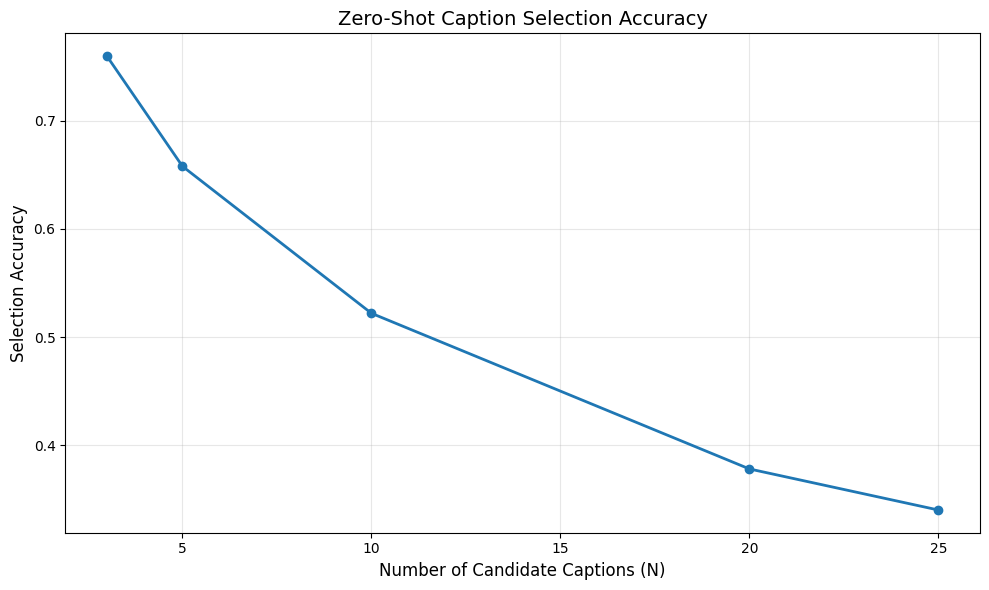


Zero-Shot Caption Selection Results:
N=3: 0.7600
N=5: 0.6580
N=10: 0.5220
N=20: 0.3780
N=25: 0.3400


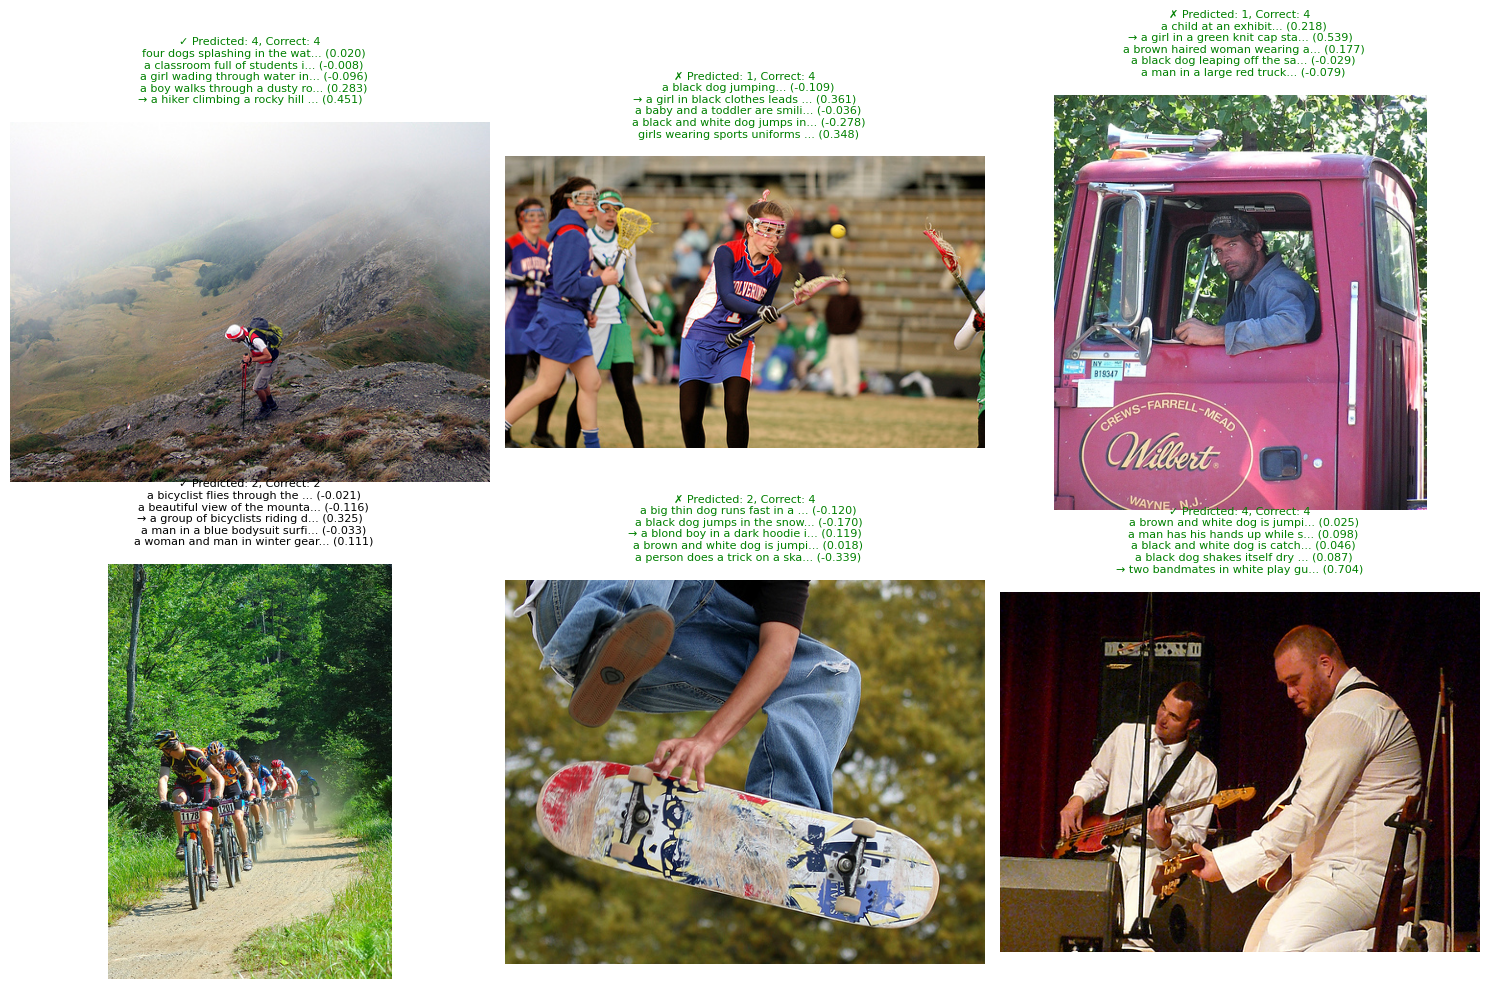

In [6]:
# TODO: Implemnt
def zero_shot_caption_selection(model, val_dataset, vocab, N_values=[3, 5, 10, 20, 25],
                                num_samples=500, device=device):
    model.eval()
    results = {N: [] for N in N_values}
    examples = []

    # Create image-to-captions mapping
    img_to_captions = defaultdict(list)
    for item in val_dataset.data:
        img_to_captions[item[0]].append(item[1])

    unique_images = list(img_to_captions.keys())
    random.shuffle(unique_images)
    unique_images = unique_images[:num_samples]

    with torch.no_grad():
        for img_name in tqdm(unique_images, desc="Caption Selection"):
            img_path = os.path.join(val_dataset.image_dir, img_name)
            image = Image.open(img_path).convert('RGB')
            image_tensor = val_dataset.transform(image).unsqueeze(0).to(device)

            # Encode image
            image_features = model.image_encoder(image_tensor)
            image_embed = model.image_projection(image_features)
            image_embed = F.normalize(image_embed, dim=-1)

            correct_caption = img_to_captions[img_name][0]

            for N in N_values:
                # Sample negative captions
                negative_imgs = [img for img in unique_images if img != img_name]
                neg_samples = random.sample(negative_imgs, min(N-1, len(negative_imgs)))

                candidates = [correct_caption]
                for neg_img in neg_samples:
                    candidates.append(img_to_captions[neg_img][0])

                random.shuffle(candidates)
                correct_idx = candidates.index(correct_caption)

                # Encode all candidate captions
                caption_embeds = []
                for caption in candidates:
                    tokens, mask = vocab.encode(caption)
                    tokens_tensor = torch.tensor([tokens], dtype=torch.long).to(device)
                    mask_tensor = torch.tensor([mask], dtype=torch.long).to(device)

                    text_features = model.text_encoder(tokens_tensor, mask_tensor)
                    text_embed = model.text_projection(text_features)
                    text_embed = F.normalize(text_embed, dim=-1)
                    caption_embeds.append(text_embed)

                caption_embeds = torch.cat(caption_embeds, dim=0)

                # Compute similarities
                similarities = (image_embed @ caption_embeds.T).squeeze(0)
                predicted_idx = similarities.argmax().item()

                is_correct = (predicted_idx == correct_idx)
                results[N].append(is_correct)

                # Save examples
                if len(examples) < 10 and N == 5:
                    examples.append({
                        'image': image,
                        'candidates': candidates,
                        'similarities': similarities.cpu().numpy(),
                        'correct_idx': correct_idx,
                        'predicted_idx': predicted_idx,
                        'is_correct': is_correct
                    })

    # Compute accuracies
    accuracies = {N: np.mean(results[N]) for N in N_values}

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o', linewidth=2)
    plt.xlabel('Number of Candidate Captions (N)', fontsize=12)
    plt.ylabel('Selection Accuracy', fontsize=12)
    plt.title('Zero-Shot Caption Selection Accuracy', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('caption_selection_accuracy.png', dpi=150)
    plt.show()

    print("\nZero-Shot Caption Selection Results:")
    for N, acc in accuracies.items():
        print(f"N={N}: {acc:.4f}")

    # Show qualitative examples
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, example in enumerate(examples[:6]):
        ax = axes[idx]
        ax.imshow(example['image'])
        ax.axis('off')

        title = f"{'✓' if example['is_correct'] else '✗'} Predicted: {example['predicted_idx']}, Correct: {example['correct_idx']}\n"
        for i, (cap, sim) in enumerate(zip(example['candidates'], example['similarities'])):
            marker = "→" if i == example['predicted_idx'] else " "
            color = "green" if i == example['correct_idx'] else "black"
            title += f"{marker} {cap[:30]}... ({sim:.3f})\n"

        ax.set_title(title, fontsize=8, color=color)

    plt.tight_layout()
    plt.savefig('caption_selection_examples.png', dpi=150)
    plt.show()

    return accuracies, examples

# Run zero-shot evaluation
accuracies, examples = zero_shot_caption_selection(model, val_dataset, vocab, device=device)


### Improving Visual Representations with Self-Supervised Learning




The experiments above rely on representations learned solely through image–caption alignment. However, Flickr8k provides limited paired supervision, which may limit the quality of the learned visual representations and, in turn, zero-shot performance.

Self-supervised learning addresses this limitation by allowing models to learn meaningful visual structure from images alone, without relying on captions or labels.

In this part, you will improve the Vision Transformer image encoder by **pretraining it using image-only self-supervised learning**, before performing vision–language alignment.

In the self-supervised stage, the Vision Transformer is trained using **only images**, without access to captions. For each image, two different augmented views are generated, and the model is trained to produce similar representations for views of the same image while producing dissimilar representations for views of different images.

After self-supervised pretraining, initialize the vision–language model with the pretrained Vision Transformer and repeat the contrastive image–caption training described earlier. You may choose whether to freeze the Vision Transformer or fine-tune it jointly with the text encoder, as long as the choice is applied consistently.

Evaluate the resulting model using the same protocols as before: image–text retrieval with Recall@K and zero-shot caption selection for $N = 3, 5, 10, 20, 25$. Compare these results to training the Vision Transformer from scratch, and visualize the differences using appropriate plots. Briefly discuss the effect of self-supervised pretraining on representation quality and zero-shot generalization.



=== Self-Supervised Pretraining ===


SSL Epoch 1/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 1 - Loss: 3.3028


SSL Epoch 2/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 2 - Loss: 2.3368


SSL Epoch 3/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 3 - Loss: 1.6631


SSL Epoch 4/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 4 - Loss: 1.3917


SSL Epoch 5/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 5 - Loss: 1.2211


SSL Epoch 6/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 6 - Loss: 1.1014


SSL Epoch 7/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 7 - Loss: 1.0531


SSL Epoch 8/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 8 - Loss: 0.9425


SSL Epoch 9/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 9 - Loss: 0.8208


SSL Epoch 10/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 10 - Loss: 0.7629


SSL Epoch 11/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 11 - Loss: 0.6490


SSL Epoch 12/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 12 - Loss: 0.6053


SSL Epoch 13/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 13 - Loss: 0.5674


SSL Epoch 14/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 14 - Loss: 0.5336


SSL Epoch 15/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 15 - Loss: 0.5104


SSL Epoch 16/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 16 - Loss: 0.4514


SSL Epoch 17/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 17 - Loss: 0.4553


SSL Epoch 18/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 18 - Loss: 0.4315


SSL Epoch 19/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 19 - Loss: 0.4299


SSL Epoch 20/20:   0%|          | 0/102 [00:00<?, ?it/s]

SSL Epoch 20 - Loss: 0.4265

=== Training with Pretrained ViT ===


Epoch 1/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 2/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 3/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 4/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 5/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 5 (Pretrained) - Loss: 2.2217
I2T - R@1: 0.0096, R@3: 0.0282, R@5: 0.0435
T2I - R@1: 0.0084, R@3: 0.0250, R@5: 0.0415


Epoch 6/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 7/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 8/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 9/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 10/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 10 (Pretrained) - Loss: 0.7499
I2T - R@1: 0.0114, R@3: 0.0287, R@5: 0.0467
T2I - R@1: 0.0104, R@3: 0.0294, R@5: 0.0502


Epoch 11/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 12/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 13/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 14/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 15/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 15 (Pretrained) - Loss: 0.2793
I2T - R@1: 0.0091, R@3: 0.0269, R@5: 0.0438
T2I - R@1: 0.0094, R@3: 0.0267, R@5: 0.0460


Epoch 16/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 17/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 18/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 19/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 20/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 20 (Pretrained) - Loss: 0.1361
I2T - R@1: 0.0099, R@3: 0.0302, R@5: 0.0489
T2I - R@1: 0.0121, R@3: 0.0331, R@5: 0.0532


Epoch 21/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 22/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 23/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 24/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 25/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 25 (Pretrained) - Loss: 0.0834
I2T - R@1: 0.0136, R@3: 0.0339, R@5: 0.0514
T2I - R@1: 0.0109, R@3: 0.0356, R@5: 0.0581


Epoch 26/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 27/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 28/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 29/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Epoch 30/30 (Pretrained):   0%|          | 0/506 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]


Epoch 30 (Pretrained) - Loss: 0.0671
I2T - R@1: 0.0109, R@3: 0.0349, R@5: 0.0509
T2I - R@1: 0.0126, R@3: 0.0356, R@5: 0.0569

=== Comparison: Scratch vs Pretrained ===


Caption Selection:   0%|          | 0/500 [00:00<?, ?it/s]

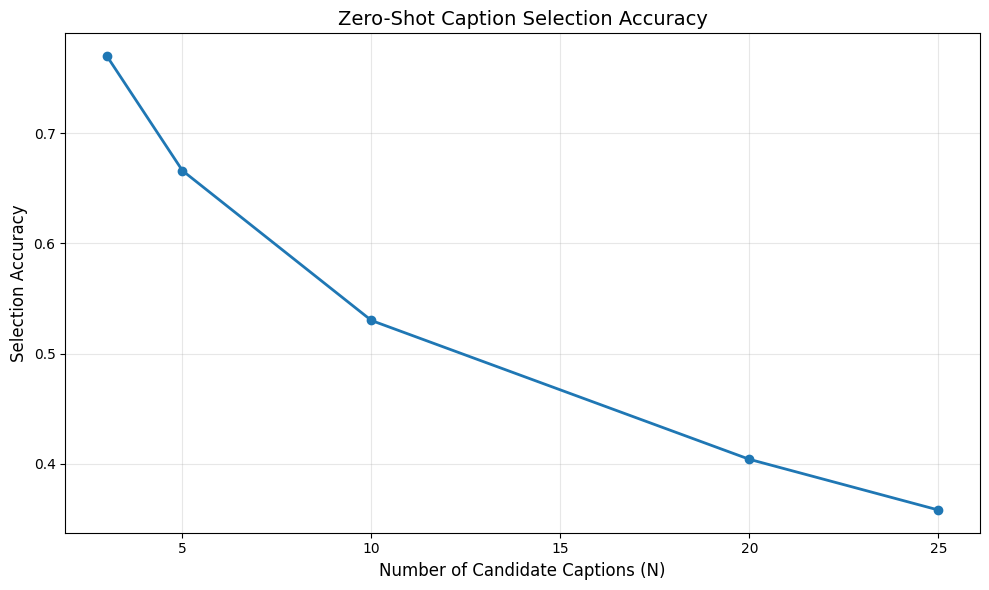


Zero-Shot Caption Selection Results:
N=3: 0.7700
N=5: 0.6660
N=10: 0.5300
N=20: 0.4040
N=25: 0.3580


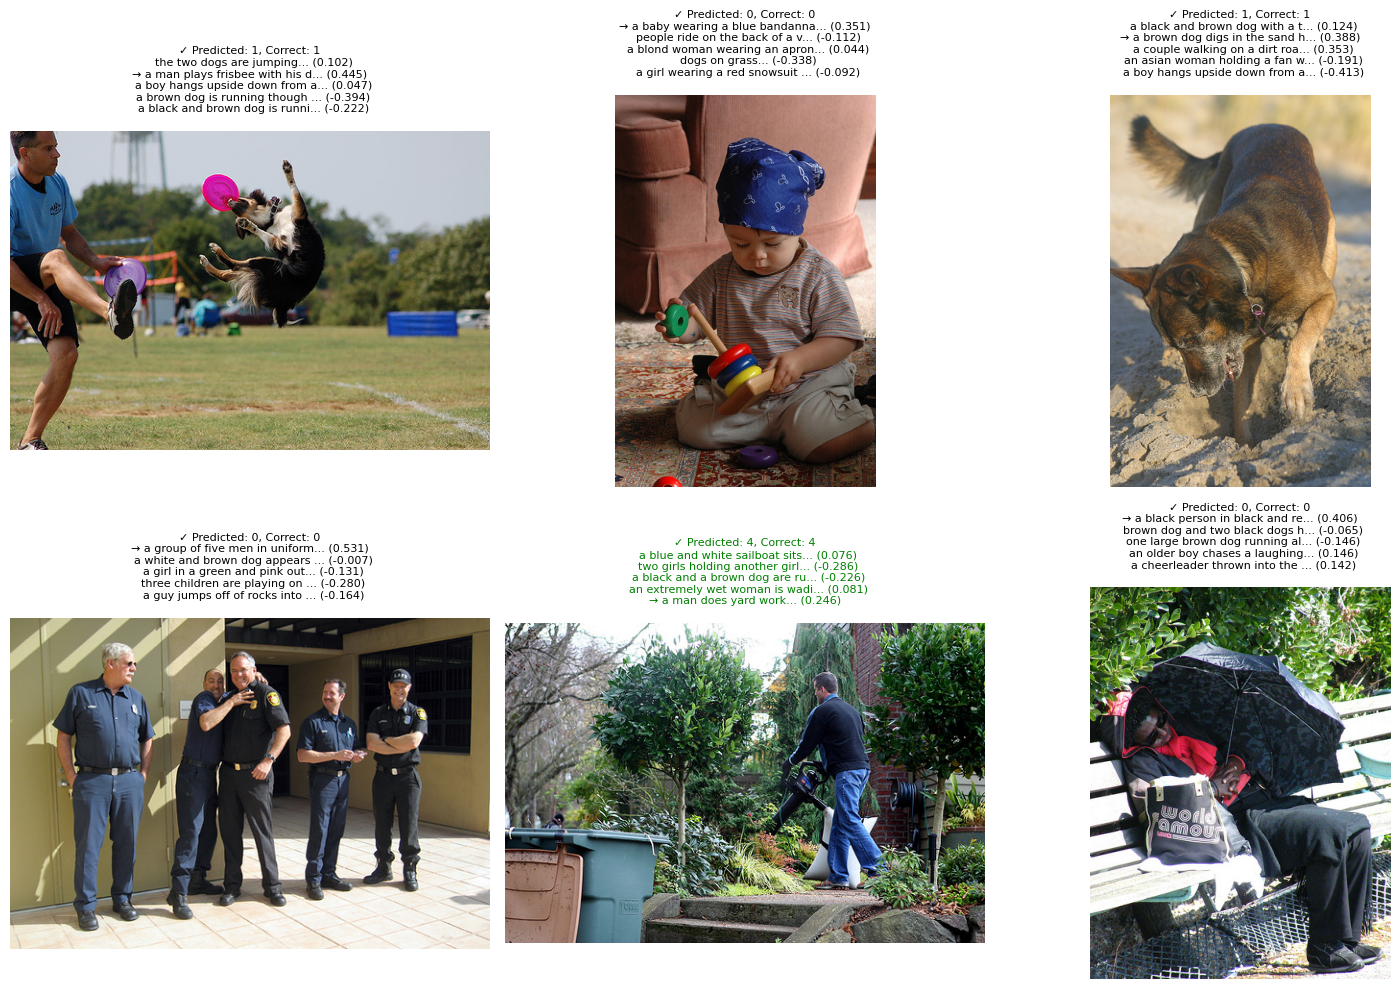

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

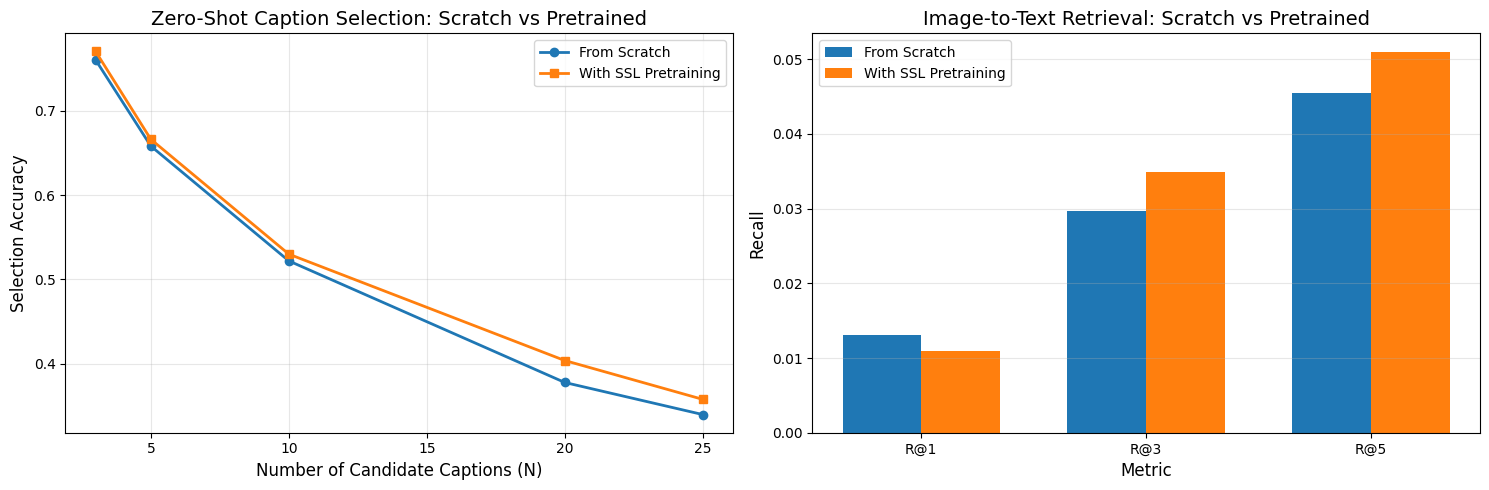


From Scratch - Caption Selection:
  N=3: 0.7600
  N=5: 0.6580
  N=10: 0.5220
  N=20: 0.3780
  N=25: 0.3400

With SSL Pretraining - Caption Selection:
  N=3: 0.7700
  N=5: 0.6660
  N=10: 0.5300
  N=20: 0.4040
  N=25: 0.3580

From Scratch - Retrieval:
  I2T R@1: 0.0131, T2I R@1: 0.0104
  I2T R@3: 0.0297, T2I R@3: 0.0269
  I2T R@5: 0.0455, T2I R@5: 0.0499

With SSL Pretraining - Retrieval:
  I2T R@1: 0.0109, T2I R@1: 0.0126
  I2T R@3: 0.0349, T2I R@3: 0.0356
  I2T R@5: 0.0509, T2I R@5: 0.0569


In [7]:
# TODO: Implement

class SelfSupervisedViT(nn.Module):
    def __init__(self, base_vit, projection_dim=256):
        super().__init__()
        self.encoder = base_vit
        self.projector = nn.Sequential(
            nn.Linear(base_vit.patch_embed.proj.out_channels, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projection = self.projector(features)
        return F.normalize(projection, dim=-1)

def get_ssl_transforms(img_size=224):
    # Strong augmentations for self-supervised learning
    return T.Compose([
        T.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        T.RandomGrayscale(p=0.2),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class SSLDataset(Dataset):
    def __init__(self, image_dir, image_names, transform):
        self.image_dir = image_dir
        self.image_names = image_names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Create two augmented views
        view1 = self.transform(image)
        view2 = self.transform(image)

        return view1, view2

# Self-supervised pretraining
ssl_transform = get_ssl_transforms()
ssl_dataset = SSLDataset(image_dir, train_imgs, ssl_transform)
ssl_loader = DataLoader(ssl_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Create ViT for self-supervised learning
ssl_vit = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=embed_dim,
    depth=6,
    n_heads=8
).to(device)

ssl_model = SelfSupervisedViT(ssl_vit, projection_dim=256).to(device)
ssl_optimizer = torch.optim.AdamW(ssl_model.parameters(), lr=1e-4, weight_decay=0.01)
ssl_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(ssl_optimizer, T_max=20)

# Self-supervised training
ssl_epochs = 20
print("\n=== Self-Supervised Pretraining ===")

for epoch in range(ssl_epochs):
    ssl_model.train()
    total_loss = 0

    pbar = tqdm(ssl_loader, desc=f"SSL Epoch {epoch+1}/{ssl_epochs}")
    for view1, view2 in pbar:
        view1, view2 = view1.to(device), view2.to(device)

        ssl_optimizer.zero_grad()

        # Get embeddings for both views
        z1 = ssl_model(view1)
        z2 = ssl_model(view2)

        # Contrastive loss between views
        loss = contrastive_loss(z1, z2, torch.tensor(1.0/0.07).to(device))

        loss.backward()
        ssl_optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(ssl_loader)
    ssl_scheduler.step()
    print(f"SSL Epoch {epoch+1} - Loss: {avg_loss:.4f}")

# Save pretrained ViT
torch.save(ssl_vit.state_dict(), 'pretrained_vit.pth')

# Train vision-language model with pretrained ViT
print("\n=== Training with Pretrained ViT ===")

model_pretrained = VisionLanguageModel(
    vocab_size=len(vocab),
    embed_dim=embed_dim,
    projection_dim=projection_dim,
    vit_depth=6,
    text_depth=6,
    n_heads=8
).to(device)

# Load pretrained weights
model_pretrained.image_encoder.load_state_dict(ssl_vit.state_dict())

optimizer_pt = torch.optim.AdamW(model_pretrained.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler_pt = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pt, T_max=num_epochs)

best_recall_pt = 0
for epoch in range(num_epochs):
    model_pretrained.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Pretrained)")
    for batch in pbar:
        images = batch['image'].to(device)
        caption_ids = batch['caption_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        optimizer_pt.zero_grad()

        image_embeds, text_embeds = model_pretrained(images, caption_ids, attention_mask)
        loss = contrastive_loss(image_embeds, text_embeds, model_pretrained.get_temperature())

        loss.backward()
        optimizer_pt.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    scheduler_pt.step()

    if (epoch + 1) % 5 == 0:
        results = evaluate_retrieval(model_pretrained, val_loader, device)
        print(f"\nEpoch {epoch+1} (Pretrained) - Loss: {avg_loss:.4f}")
        print(f"I2T - R@1: {results['i2t_R@1']:.4f}, R@3: {results['i2t_R@3']:.4f}, R@5: {results['i2t_R@5']:.4f}")
        print(f"T2I - R@1: {results['t2i_R@1']:.4f}, R@3: {results['t2i_R@3']:.4f}, R@5: {results['t2i_R@5']:.4f}")

        avg_recall = (results['i2t_R@1'] + results['t2i_R@1']) / 2
        if avg_recall > best_recall_pt:
            best_recall_pt = avg_recall
            torch.save(model_pretrained.state_dict(), 'best_model_pretrained.pth')

# Compare results
print("\n=== Comparison: Scratch vs Pretrained ===")

# Zero-shot evaluation for pretrained model
accuracies_pt, _ = zero_shot_caption_selection(model_pretrained, val_dataset, vocab, device=device)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Caption selection comparison
N_values = [3, 5, 10, 20, 25]
ax1.plot(N_values, [accuracies[n] for n in N_values], marker='o', label='From Scratch', linewidth=2)
ax1.plot(N_values, [accuracies_pt[n] for n in N_values], marker='s', label='With SSL Pretraining', linewidth=2)
ax1.set_xlabel('Number of Candidate Captions (N)', fontsize=12)
ax1.set_ylabel('Selection Accuracy', fontsize=12)
ax1.set_title('Zero-Shot Caption Selection: Scratch vs Pretrained', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Retrieval comparison (using final epoch results)
results_scratch = evaluate_retrieval(model, val_loader, device)
results_pretrained = evaluate_retrieval(model_pretrained, val_loader, device)

metrics = ['R@1', 'R@3', 'R@5']
scratch_i2t = [results_scratch[f'i2t_{m}'] for m in metrics]
pretrained_i2t = [results_pretrained[f'i2t_{m}'] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

ax2.bar(x - width/2, scratch_i2t, width, label='From Scratch')
ax2.bar(x + width/2, pretrained_i2t, width, label='With SSL Pretraining')
ax2.set_xlabel('Metric', fontsize=12)
ax2.set_ylabel('Recall', fontsize=12)
ax2.set_title('Image-to-Text Retrieval: Scratch vs Pretrained', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('comparison_scratch_vs_pretrained.png', dpi=150)
plt.show()

print("\nFrom Scratch - Caption Selection:")
for N, acc in accuracies.items():
    print(f"  N={N}: {acc:.4f}")

print("\nWith SSL Pretraining - Caption Selection:")
for N, acc in accuracies_pt.items():
    print(f"  N={N}: {acc:.4f}")

print("\nFrom Scratch - Retrieval:")
for k in ['R@1', 'R@3', 'R@5']:
    print(f"  I2T {k}: {results_scratch[f'i2t_{k}']:.4f}, T2I {k}: {results_scratch[f't2i_{k}']:.4f}")

print("\nWith SSL Pretraining - Retrieval:")
for k in ['R@1', 'R@3', 'R@5']:
    print(f"  I2T {k}: {results_pretrained[f'i2t_{k}']:.4f}, T2I {k}: {results_pretrained[f't2i_{k}']:.4f}")

### Reflection



Answer the following questions in your own words.  
Your answers should demonstrate **conceptual understanding** rather than implementation details.

1. The model is trained using a contrastive objective on image–caption pairs, yet it is evaluated on caption selection without being trained for this task explicitly. Explain why this is possible, and what properties of the learned embedding space make zero-shot inference feasible.

2. Vision Transformers do not incorporate strong spatial inductive biases, unlike convolutional neural networks. Based on your experiments, discuss how this design choice affects learning in the low-data regime of Flickr8k, both before and after self-supervised pretraining.

3. Self-supervised pretraining improves downstream performance even though no captions are used during this stage. Explain what types of information the Vision Transformer can learn during self-supervised pretraining that are useful for vision–language alignment later.

4. Contrastive learning relies on negative examples drawn from within a mini-batch. Discuss how batch size influences the quality of learned representations, and how this consideration relates to both multimodal alignment and self-supervised learning.
